# **Evaluation of Feature Enhancement**  
  
  

## **Contents**
1. [Importing Libraries](evaluation_of_feature_enhancement.ipynb#1-importing-libraries)  
   
2. [Load Results](evaluation_of_feature_enhancement.ipynb#2-load-results)  
   
3. [RMSE and MAE](evaluation_of_feature_enhancement.ipynb#3-rmse-and-mae)  
   - 3.1 [RMSE and MAE Statistical Analysis](evaluation_of_feature_enhancement.ipynb#3.1-rmse-and-mae-statistical-analysis)  
  
4. [CG-EGA Summary Classification](evaluation_of_feature_enhancement.ipynb#4-cg-ega-summary-classification)
   - 4.1 [CG-EGA Summary Classification Statistical Analysis](evaluation_of_feature_enhancement.ipynb#4.1-cg-ega-summary-classification-statistical-analysis)  
  


## **1. Importing Libraries**

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from IPython.display import display


current_dir = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(current_dir, "../../../../../"))

sys.path.append(os.path.join(PROJECT_ROOT, "shared_utilities"))
from metrics import *



## **2. Load Results**

In [ ]:
"""jpformer without feature enhancement"""

no_fe_directory = os.path.join(PROJECT_ROOT, "models", "jpformer","development_training_files", "feature_enhancement")

jpformer_no_fe_cgega_summary = pd.read_csv(os.path.join(no_fe_directory, "without_feature_enhancement/overall_cg_ega.csv"))

jpformer_no_fe_full_results = pd.read_csv(os.path.join(no_fe_directory, "without_feature_enhancement/detailed_results_table.csv"))

"""jpformer with feature enhancement"""

fe_directory = os.path.join(PROJECT_ROOT, "models", "jpformer","development_training_files", "feature_enhancement")

jpformer_fe_cgega_summary = pd.read_csv(os.path.join(fe_directory, "with_feature_enhancement/overall_cg_ega.csv"))

jpformer_fe_full_results = pd.read_csv(os.path.join(fe_directory, "with_feature_enhancement/detailed_results_table.csv"))

## **3. RMSE and MAE**

In [82]:
# Define a simple RMSE function
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

no_fe_rmse = calculate_rmse(jpformer_no_fe_full_results['true_glucose'], jpformer_no_fe_full_results['predicted_glucose'])
fe_rmse = calculate_rmse(jpformer_fe_full_results['true_glucose'], jpformer_fe_full_results['predicted_glucose'])


def mae(predictions, targets):
    return np.mean(np.abs(predictions - targets))

no_fe_mae = mae(jpformer_no_fe_full_results['true_glucose'], jpformer_no_fe_full_results['predicted_glucose'])
fe_mae = mae(jpformer_fe_full_results['true_glucose'], jpformer_fe_full_results['predicted_glucose'])

def mape(predictions, targets):
    return np.mean(np.abs((predictions - targets) / targets)) * 100

no_fe_mape = mape(jpformer_no_fe_full_results['true_glucose'], jpformer_no_fe_full_results['predicted_glucose'])
fe_mape = mape(jpformer_fe_full_results['true_glucose'], jpformer_fe_full_results['predicted_glucose'])


In [83]:
# create table with model in 1st column and rmse and mae in 2nd and 3rd columns
rmse_mape_table = pd.DataFrame({'model': ['Without feature enhancement', 'With feature enhancement'], 'RMSE': [no_fe_rmse, fe_rmse], 'MAPE': [no_fe_mape, fe_mape]})
rmse_mape_table


,model,RMSE,MAPE
0,Without feature enhancement,36.305685,17.338038
1,With feature enhancement,35.128274,16.705403


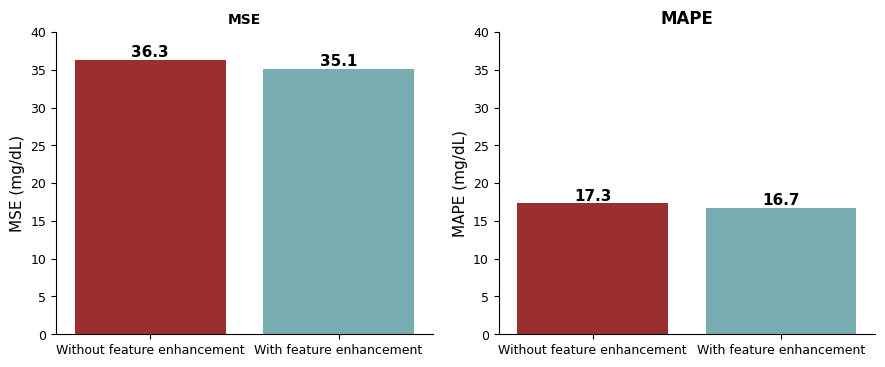

In [89]:
# plot comparison column chart for RMSE and MAE and display in a 2x1 grid
fig, axs = plt.subplots(1, 2, figsize=(9,4))

# Define custom colors for the models
model1_color = (173 / 255, 29 / 255, 30 / 255)  # Without Feature Enhancement
model2_color = (110 / 255, 180 / 255, 186 / 255)  # With Feature Enhancement
palette = [model1_color, model2_color]

# Plot RMSE
sns.barplot(x='model', y='RMSE', data=rmse_mape_table, ax=axs[0], hue='model', palette=palette, legend=False)
axs[0].set_title('MSE', fontsize=10, fontweight='bold')
axs[0].set_ylabel('MSE (mg/dL)', fontsize=11)
axs[0].set_xlabel('')  # Remove x-axis label

# Plot MAE
sns.barplot(x='model', y='MAPE', data=rmse_mape_table, ax=axs[1], hue='model', palette=palette, legend=False)
axs[1].set_title('MAPE', fontsize=12, fontweight='bold')
axs[1].set_ylabel('MAPE (mg/dL)', fontsize=11)
axs[1].set_xlabel('')  # Remove x-axis label

# Set y-axis limits and add data labels
for ax in axs:
    ax.set_ylim(0, 40)  # Adjusted to better fit the data range
    # Make tick labels smaller
    ax.tick_params(axis='both', labelsize=9)
    # Add data labels
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}", 
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='bottom', fontsize=11, fontweight='bold')
    # Remove top and right borders
    sns.despine(ax=ax)



plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust to make room for the title
plt.show()


### **3.1 RMSE and MAE Statistical Analysis**

In [108]:
def return_ttests(no_fe_model, fe_model, glycemic_region, model1_name="Model w/o FE", model2_name="Model w/ FE"):
    print(f"\n🔍 Running t-test for {model1_name} vs {model2_name} ({glycemic_region.capitalize()}glycaemic Range Performance):\n")

    # Copy data to avoid modifying the originals
    df1 = no_fe_model.copy()
    df2 = fe_model.copy()

    # Filter based on glycemic region
    glycemic_region = glycemic_region.lower()
    if glycemic_region == 'hypo':
        df1 = df1[df1['glycemic_region'] == 'hypo']
        df2 = df2[df2['glycemic_region'] == 'hypo']
    elif glycemic_region == 'hyper':
        df1 = df1[df1['glycemic_region'] == 'hyper']
        df2 = df2[df2['glycemic_region'] == 'hyper']
    elif glycemic_region == 'eu':
        df1 = df1[df1['glycemic_region'] == 'eu']
        df2 = df2[df2['glycemic_region'] == 'eu']
    else:
        pass  # Use all data if 'overall' or invalid

    # Calculate errors
    df1['absolute_error'] = np.abs(df1['true_glucose'] - df1['predicted_glucose'])
    df2['absolute_error'] = np.abs(df2['true_glucose'] - df2['predicted_glucose'])

    df1['squared_error'] = df1['absolute_error'] ** 2
    df2['squared_error'] = df2['absolute_error'] ** 2
    
    # Calculate percentage errors for MAPE
    df1['percentage_error'] = np.abs((df1['true_glucose'] - df1['predicted_glucose']) / df1['true_glucose']) * 100
    df2['percentage_error'] = np.abs((df2['true_glucose'] - df2['predicted_glucose']) / df2['true_glucose']) * 100

    # Use Welch's t-test (unpaired, unequal variance)
    tt_mae, p_mae = stats.ttest_ind(df1['absolute_error'], df2['absolute_error'], equal_var=False)
    tt_mse, p_mse = stats.ttest_ind(df1['squared_error'], df2['squared_error'], equal_var=False)
    tt_mape, p_mape = stats.ttest_ind(df1['percentage_error'], df2['percentage_error'], equal_var=False)

    # Format results
    results = pd.DataFrame({
        "Metric": ["MAE", "MSE", "MAPE"],
        "t-statistic": [tt_mae, tt_mse, tt_mape],
        "p-value": [p_mae, p_mse, p_mape],
        "Significance (p < 0.05)": [p_mae < 0.05, p_mse < 0.05, p_mape < 0.05]
    })

    display(results)
    return results

In [109]:
overall_ttests = return_ttests(jpformer_no_fe_full_results, jpformer_fe_full_results, 'overall', model1_name="JPformer w/o FE", model2_name="JPformer w/ FE")


🔍 Running t-test for JPformer w/o FE vs JPformer w/ FE (Overallglycaemic Range Performance):



,Metric,t-statistic,p-value,Significance (p < 0.05)
0,MAE,96.114721,0.000000e+00,True
1,MSE,36.228427,2.318504e-287,True
2,MAPE,79.272493,0.000000e+00,True


In [94]:
hypo_ttests = return_ttests(jpformer_no_fe_full_results, jpformer_fe_full_results, 'hypo', model1_name="JPformer w/o FE", model2_name="JPformer w/ FE")


🔍 Running t-test for JPformer w/o FE vs JPformer w/ FE (Hypoglycaemic Range Performance):



,Metric,t-statistic,p-value,Significance (p < 0.05)
0,MAE,12.198068,3.253573e-34,True
1,MSE,7.980072,1.468502e-15,True
2,MAPE,12.461214,1.244506e-35,True


In [95]:
eu_ttests = return_ttests(jpformer_no_fe_full_results, jpformer_fe_full_results, 'eu', model1_name="JPformer w/o FE", model2_name="JPformer w/ FE")


🔍 Running t-test for JPformer w/o FE vs JPformer w/ FE (Euglycaemic Range Performance):



,Metric,t-statistic,p-value,Significance (p < 0.05)
0,MAE,110.394416,0.0,True
1,MSE,65.310739,0.0,True
2,MAPE,95.296192,0.0,True


In [96]:
hyper_ttests = return_ttests(jpformer_no_fe_full_results, jpformer_fe_full_results, 'hyper', model1_name="JPformer w/o FE", model2_name="JPformer w/ FE")


🔍 Running t-test for JPformer w/o FE vs JPformer w/ FE (Hyperglycaemic Range Performance):



,Metric,t-statistic,p-value,Significance (p < 0.05)
0,MAE,27.953083,6.509013e-172,True
1,MSE,-0.524298,6.000711e-01,False
2,MAPE,36.569339,1.089605e-292,True


## **4. CG-EGA Summary Classifications**

In [ ]:
# ADD BINARY COLUM FOR ACCURATE PREDICTION BASED ON CGEGA_CLASS COLUMN
jpformer_no_fe_full_results['AP'] = np.where(jpformer_no_fe_full_results['CG_EGA_Class'] == 'AP', 1, 0)
jpformer_no_fe_full_results['BE'] = np.where(jpformer_no_fe_full_results['CG_EGA_Class'] == 'BE', 1, 0)
jpformer_no_fe_full_results['EP'] = np.where(jpformer_no_fe_full_results['CG_EGA_Class'] == 'EP', 1, 0)


jpformer_fe_full_results['AP'] = np.where(jpformer_fe_full_results['CG_EGA_Class'] == 'AP', 1, 0)
jpformer_fe_full_results['BE'] = np.where(jpformer_fe_full_results['CG_EGA_Class'] == 'BE', 1, 0)
jpformer_fe_full_results['EP'] = np.where(jpformer_fe_full_results['CG_EGA_Class'] == 'EP', 1, 0)

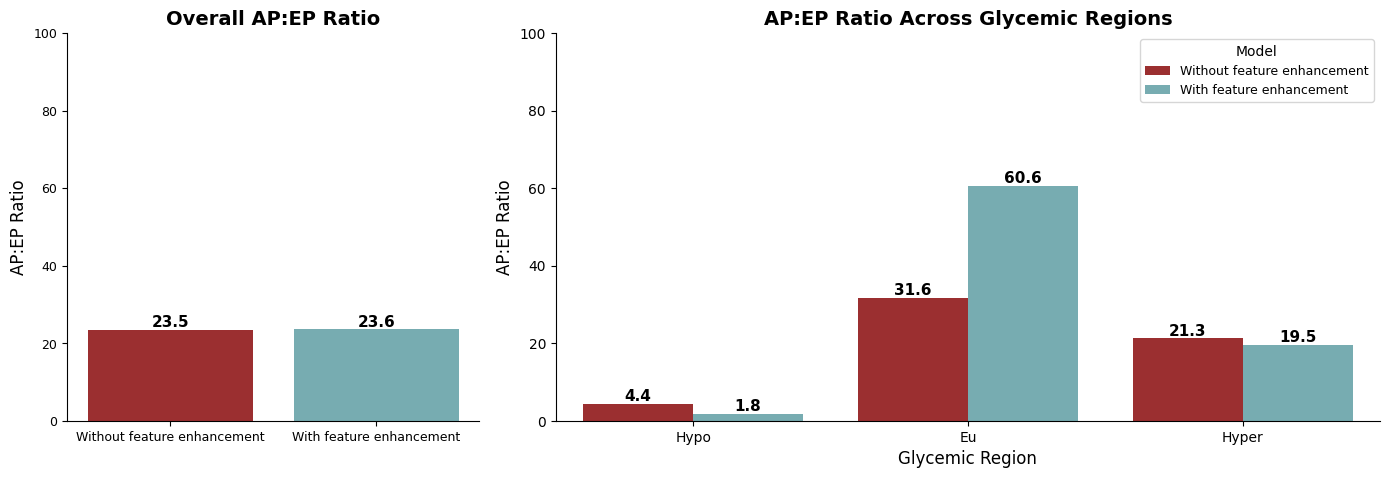

In [56]:
# Define custom colors for the models
model1_color = (173 / 255, 29 / 255, 30 / 255)  # Without Feature Enhancement
model2_color = (110 / 255, 180 / 255, 186 / 255)  # With Feature Enhancement
palette = [model1_color, model2_color]

# Create summary tables for overall, hypo, eu, and hyper glycaemic regions
regions = ['overall', 'hypo', 'eu', 'hyper']
summary_tables = {}

for region in regions:
    # Initialize empty DataFrame with specific dtypes to avoid warning
    summary_df = pd.DataFrame({
        'Model': pd.Series(dtype='object'),
        'AP': pd.Series(dtype='int64'), 
        'BE': pd.Series(dtype='int64'), 
        'EP': pd.Series(dtype='int64'), 
        'Count': pd.Series(dtype='int64'),
        'AP_pct': pd.Series(dtype='float64'), 
        'BE_pct': pd.Series(dtype='float64'), 
        'EP_pct': pd.Series(dtype='float64')
    })
    
    # Process each model
    for model, df in zip(['Without feature enhancement', 'With feature enhancement'], 
                        [jpformer_no_fe_full_results, jpformer_fe_full_results]):
        
        # Filter for region if not overall
        if region != 'overall':
            region_df = df[df['glycemic_region'] == region]
        else:
            region_df = df
            
        # Calculate counts
        ap_count = region_df['AP'].sum()
        be_count = region_df['BE'].sum()
        ep_count = region_df['EP'].sum()
        total_count = len(region_df)
        
        # Create a new row as a dictionary and append it to the DataFrame
        new_row = {
            'Model': model, 
            'AP': ap_count, 
            'BE': be_count, 
            'EP': ep_count, 
            'Count': total_count,
            'AP:EP': ap_count / ep_count if ep_count != 0 else np.nan,
            'AP_pct': ap_count / total_count * 100, 
            'BE_pct': be_count / total_count * 100, 
            'EP_pct': ep_count / total_count * 100
        }
        summary_df = pd.concat([summary_df, pd.DataFrame([new_row])], ignore_index=True)
    
    # Store in dictionary
    summary_tables[region] = summary_df

# Create 1x2 grid figure with custom width ratios
fig, axs = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 2]})

# PLOT 1: Overall AP:EP ratio (left panel)
sns.barplot(
    x='Model', 
    y='AP:EP', 
    data=summary_tables['overall'], 
    ax=axs[0], 
    palette=palette,
    hue='Model',
    legend=False
)
axs[0].set_title('Overall AP:EP Ratio', fontsize=14, fontweight='bold')
axs[0].set_ylabel('AP:EP Ratio', fontsize=12)
axs[0].set_xlabel('')  # Remove x-axis label
axs[0].tick_params(axis='both', labelsize=9)
axs[0].set_ylim(0, 100)  # Set y-axis range from 0 to 100

# Add data labels
for p in axs[0].patches:
    axs[0].annotate(f"{p.get_height():.1f}", 
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='bottom', fontsize=11, fontweight='bold')

# PLOT 2: AP:EP by Glycemic Region (right panel)
# Create a new dataframe that combines the regional data for plotting
regional_data = pd.concat([
    summary_tables['hypo'][['Model', 'AP:EP']].assign(Region='Hypo'),
    summary_tables['eu'][['Model', 'AP:EP']].assign(Region='Eu'),
    summary_tables['hyper'][['Model', 'AP:EP']].assign(Region='Hyper')
])

sns.barplot(
    x='Region', 
    y='AP:EP', 
    hue='Model',
    data=regional_data, 
    ax=axs[1], 
    palette=palette
)
axs[1].set_title('AP:EP Ratio Across Glycemic Regions', fontsize=14, fontweight='bold')
axs[1].set_ylabel('AP:EP Ratio', fontsize=12)
axs[1].set_xlabel('Glycemic Region', fontsize=12)
axs[1].tick_params(axis='both', labelsize=10)
axs[1].set_ylim(0, 100)  # Set y-axis range from 0 to 100

# Add data labels to the second chart
for container in axs[1].containers:
    axs[1].bar_label(container, fmt='%.1f', fontsize=11, fontweight='bold')


# Add legend to the right plot
axs[1].legend(title='Model', fontsize=9, title_fontsize=10)

# Remove top and right borders
sns.despine(ax=axs[0])
sns.despine(ax=axs[1])


plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust to make room for the title
plt.show()


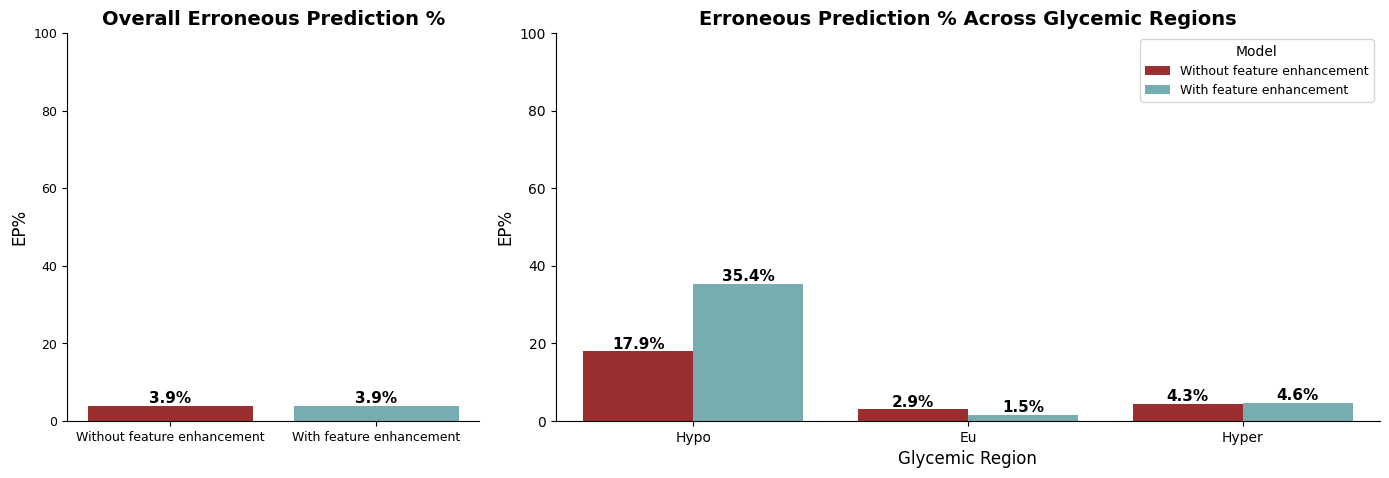

In [67]:
# Define custom colors for the models
model1_color = (173 / 255, 29 / 255, 30 / 255)  # Without Feature Enhancement
model2_color = (110 / 255, 180 / 255, 186 / 255)  # With Feature Enhancement
palette = [model1_color, model2_color]

# Create summary tables for overall, hypo, eu, and hyper glycaemic regions
regions = ['overall', 'hypo', 'eu', 'hyper']
summary_tables = {}

for region in regions:
    # Initialize empty DataFrame with specific dtypes to avoid warning
    summary_df = pd.DataFrame({
        'Model': pd.Series(dtype='object'),
        'AP': pd.Series(dtype='int64'), 
        'BE': pd.Series(dtype='int64'), 
        'EP': pd.Series(dtype='int64'), 
        'Count': pd.Series(dtype='int64'),
        'AP_pct': pd.Series(dtype='float64'), 
        'BE_pct': pd.Series(dtype='float64'), 
        'EP_pct': pd.Series(dtype='float64')
    })
    
    # Process each model
    for model, df in zip(['Without feature enhancement', 'With feature enhancement'], 
                        [jpformer_no_fe_full_results, jpformer_fe_full_results]):
        
        # Filter for region if not overall
        if region != 'overall':
            region_df = df[df['glycemic_region'] == region]
        else:
            region_df = df
            
        # Calculate counts
        ap_count = region_df['AP'].sum()
        be_count = region_df['BE'].sum()
        ep_count = region_df['EP'].sum()
        total_count = len(region_df)
        
        # Create a new row as a dictionary and append it to the DataFrame
        new_row = {
            'Model': model, 
            'AP': ap_count, 
            'BE': be_count, 
            'EP': ep_count, 
            'Count': total_count,
            'AP:EP': ap_count / ep_count if ep_count != 0 else np.nan,
            'AP_pct': ap_count / total_count * 100, 
            'BE_pct': be_count / total_count * 100, 
            'EP_pct': ep_count / total_count * 100
        }
        summary_df = pd.concat([summary_df, pd.DataFrame([new_row])], ignore_index=True)
    
    # Store in dictionary
    summary_tables[region] = summary_df

# Create 1x2 grid figure with custom width ratios
fig, axs = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 2]})

# PLOT 1: Overall EP% (left panel)
sns.barplot(
    x='Model', 
    y='EP_pct', 
    data=summary_tables['overall'], 
    ax=axs[0], 
    palette=palette,
    hue='Model',
    legend=False
)
axs[0].set_title('Overall Erroneous Prediction %', fontsize=14, fontweight='bold')
axs[0].set_ylabel('EP%', fontsize=12)
axs[0].set_xlabel('')  # Remove x-axis label
axs[0].tick_params(axis='both', labelsize=9)
axs[0].set_ylim(0, 100)  # Set y-axis range from 0 to 5

# Add data labels
for p in axs[0].patches:
    axs[0].annotate(f"{p.get_height():.1f}%", 
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='bottom', fontsize=11, fontweight='bold')

# PLOT 2: EP% by Glycemic Region (right panel)
# Create a new dataframe that combines the regional data for plotting
regional_data = pd.concat([
    summary_tables['hypo'][['Model', 'EP_pct']].assign(Region='Hypo'),
    summary_tables['eu'][['Model', 'EP_pct']].assign(Region='Eu'),
    summary_tables['hyper'][['Model', 'EP_pct']].assign(Region='Hyper')
])

sns.barplot(
    x='Region', 
    y='EP_pct', 
    hue='Model',
    data=regional_data, 
    ax=axs[1], 
    palette=palette
)
axs[1].set_title('Erroneous Prediction % Across Glycemic Regions', fontsize=14, fontweight='bold')
axs[1].set_ylabel('EP%', fontsize=12)
axs[1].set_xlabel('Glycemic Region', fontsize=12)
axs[1].tick_params(axis='both', labelsize=10)
axs[1].set_ylim(0, 100)  # Set y-axis range from 0 to 40 to accommodate hypo region values

# Add data labels to the second chart
for container in axs[1].containers:
    axs[1].bar_label(container, fmt='%.1f%%', fontsize=11, fontweight='bold')

# Add legend to the right plot
axs[1].legend(title='Model', fontsize=9, title_fontsize=10)

# Remove top and right borders
sns.despine(ax=axs[0])
sns.despine(ax=axs[1])

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust to make room for the title
plt.show()


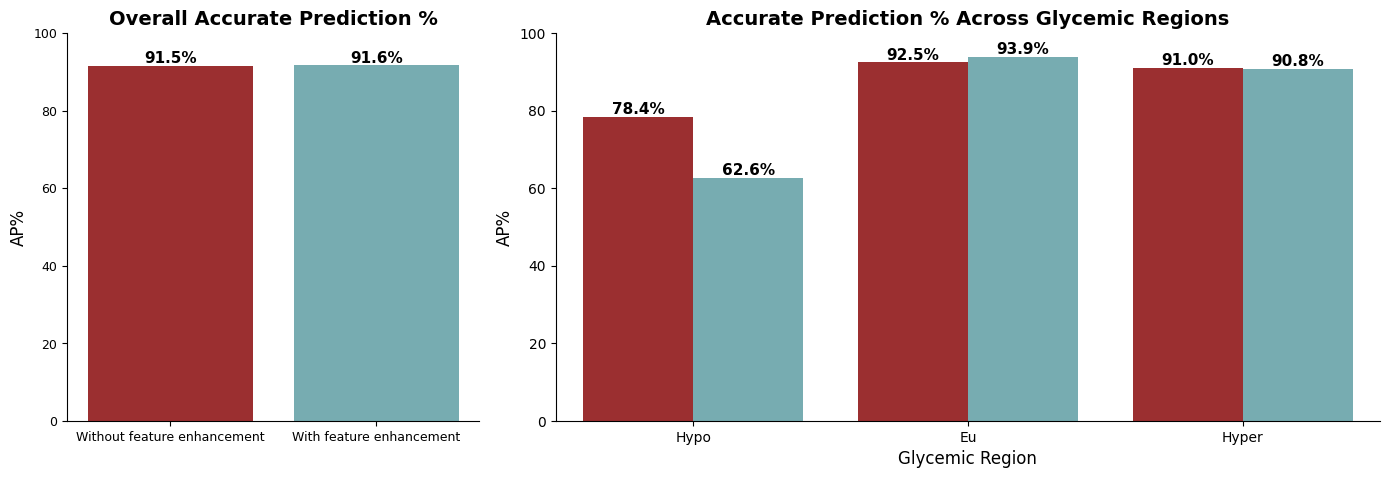

In [69]:
# Define custom colors for the models
model1_color = (173 / 255, 29 / 255, 30 / 255)  # Without Feature Enhancement
model2_color = (110 / 255, 180 / 255, 186 / 255)  # With Feature Enhancement
palette = [model1_color, model2_color]

# Create summary tables for overall, hypo, eu, and hyper glycaemic regions
regions = ['overall', 'hypo', 'eu', 'hyper']
summary_tables = {}

for region in regions:
    # Initialize empty DataFrame with specific dtypes to avoid warning
    summary_df = pd.DataFrame({
        'Model': pd.Series(dtype='object'),
        'AP': pd.Series(dtype='int64'), 
        'BE': pd.Series(dtype='int64'), 
        'EP': pd.Series(dtype='int64'), 
        'Count': pd.Series(dtype='int64'),
        'AP_pct': pd.Series(dtype='float64'), 
        'BE_pct': pd.Series(dtype='float64'), 
        'EP_pct': pd.Series(dtype='float64')
    })
    
    # Process each model
    for model, df in zip(['Without feature enhancement', 'With feature enhancement'], 
                        [jpformer_no_fe_full_results, jpformer_fe_full_results]):
        
        # Filter for region if not overall
        if region != 'overall':
            region_df = df[df['glycemic_region'] == region]
        else:
            region_df = df
            
        # Calculate counts
        ap_count = region_df['AP'].sum()
        be_count = region_df['BE'].sum()
        ep_count = region_df['EP'].sum()
        total_count = len(region_df)
        
        # Create a new row as a dictionary and append it to the DataFrame
        new_row = {
            'Model': model, 
            'AP': ap_count, 
            'BE': be_count, 
            'EP': ep_count, 
            'Count': total_count,
            'AP:EP': ap_count / ep_count if ep_count != 0 else np.nan,
            'AP_pct': ap_count / total_count * 100, 
            'BE_pct': be_count / total_count * 100, 
            'EP_pct': ep_count / total_count * 100
        }
        summary_df = pd.concat([summary_df, pd.DataFrame([new_row])], ignore_index=True)
    
    # Store in dictionary
    summary_tables[region] = summary_df

# Create 1x2 grid figure with custom width ratios
fig, axs = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 2]})

# PLOT 1: Overall AP% (left panel)
sns.barplot(
    x='Model', 
    y='AP_pct', 
    data=summary_tables['overall'], 
    ax=axs[0], 
    palette=palette,
    hue='Model',
    legend=False
)
axs[0].set_title('Overall Accurate Prediction %', fontsize=14, fontweight='bold')
axs[0].set_ylabel('AP%', fontsize=12)
axs[0].set_xlabel('')  # Remove x-axis label
axs[0].tick_params(axis='both', labelsize=9)
axs[0].set_ylim(0, 100)  # Set y-axis range from 0 to 100

# Add data labels
for p in axs[0].patches:
    axs[0].annotate(f"{p.get_height():.1f}%", 
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='bottom', fontsize=11, fontweight='bold')

# PLOT 2: AP% by Glycemic Region (right panel)
# Create a new dataframe that combines the regional data for plotting
regional_data = pd.concat([
    summary_tables['hypo'][['Model', 'AP_pct']].assign(Region='Hypo'),
    summary_tables['eu'][['Model', 'AP_pct']].assign(Region='Eu'),
    summary_tables['hyper'][['Model', 'AP_pct']].assign(Region='Hyper')
])

sns.barplot(
    x='Region', 
    y='AP_pct', 
    hue='Model',
    data=regional_data, 
    ax=axs[1], 
    palette=palette,
    legend=False
)
axs[1].set_title('Accurate Prediction % Across Glycemic Regions', fontsize=14, fontweight='bold')
axs[1].set_ylabel('AP%', fontsize=12)
axs[1].set_xlabel('Glycemic Region', fontsize=12)
axs[1].tick_params(axis='both', labelsize=10)
axs[1].set_ylim(0, 100)  # Set y-axis range from 0 to 100

# Add data labels to the second chart
for container in axs[1].containers:
    axs[1].bar_label(container, fmt='%.1f%%', fontsize=11, fontweight='bold')

# Add legend to the right plot


# Remove top and right borders
sns.despine(ax=axs[0])
sns.despine(ax=axs[1])

plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust to make room for the title
plt.show()


Overall Summary:


,Model,AP,BE,EP,Count,AP_pct,BE_pct,EP_pct,AP:EP
0,Without feature enhancement,3115416,157269,132819,3405504,91.481789,4.618083,3.900128,23.456102
1,With feature enhancement,2982336,145416,126528,3254280,91.643497,4.468454,3.888049,23.570561



Hypo Region Summary:


,Model,AP,BE,EP,Count,AP_pct,BE_pct,EP_pct,AP:EP
0,Without feature enhancement,98011,4622,22416,125049,78.378076,3.696151,17.925773,4.372368
1,With feature enhancement,82187,2684,46476,131347,62.572423,2.043442,35.384135,1.768375



Eu Region Summary:


,Model,AP,BE,EP,Count,AP_pct,BE_pct,EP_pct,AP:EP
0,Without feature enhancement,2042228,101993,64539,2208760,92.460385,4.617659,2.921956,31.643316
1,With feature enhancement,1971850,95720,32546,2100116,93.892433,4.557843,1.549724,60.586554



Hyper Region Summary:


,Model,AP,BE,EP,Count,AP_pct,BE_pct,EP_pct,AP:EP
0,Without feature enhancement,975177,50654,45864,1071695,90.993893,4.726531,4.279576,21.262363
1,With feature enhancement,928299,47012,47506,1022817,90.759051,4.596326,4.644624,19.540669


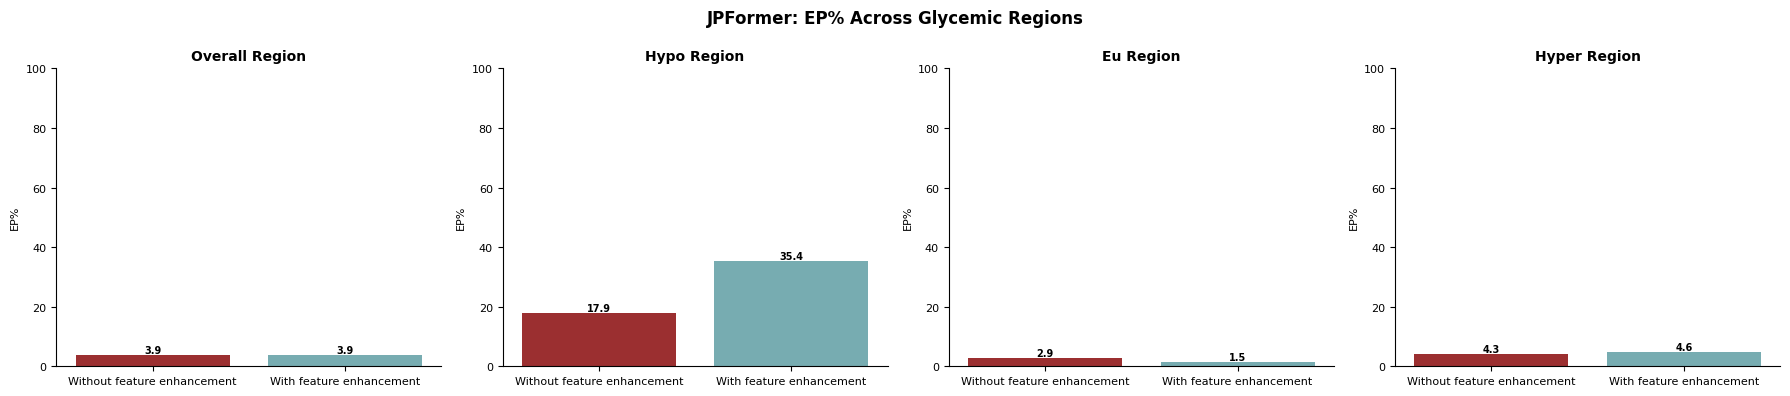

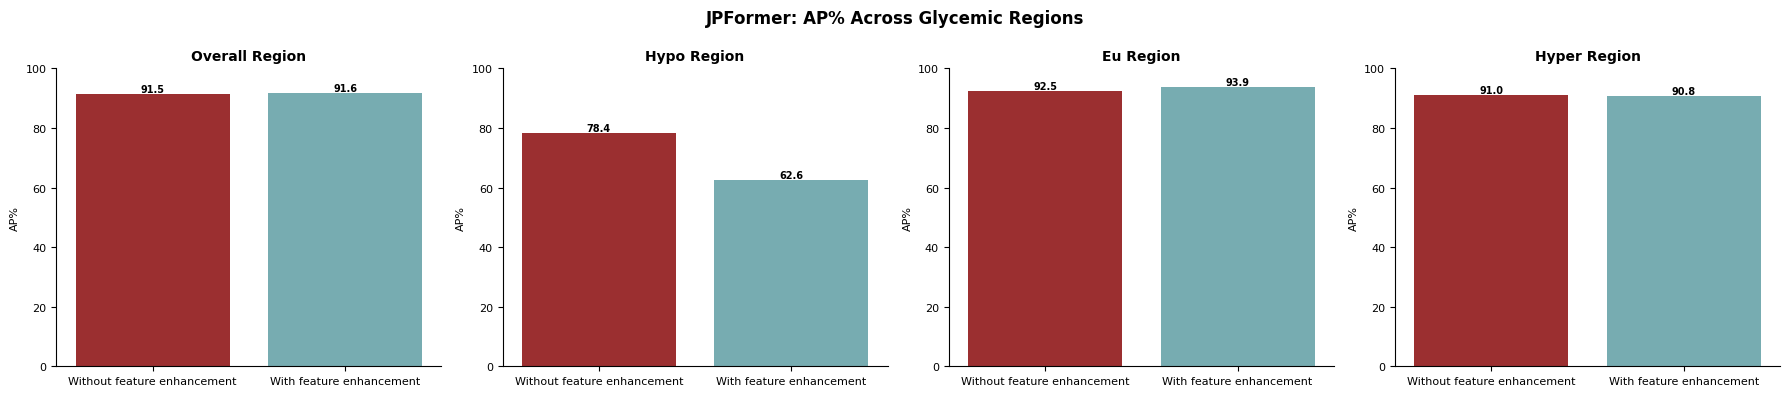

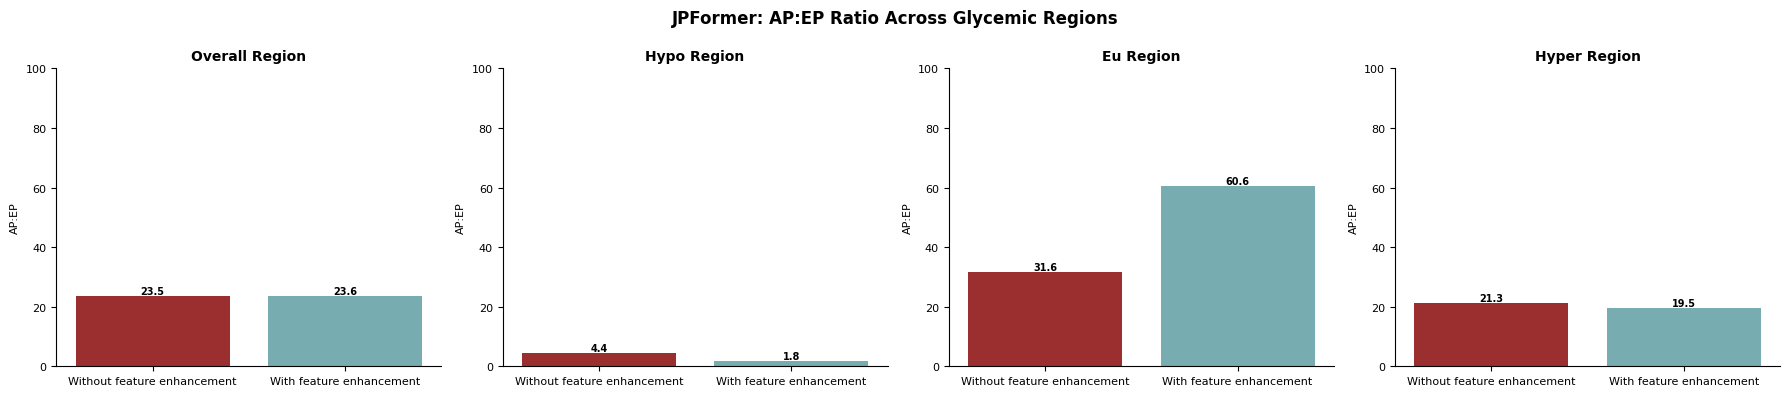

In [13]:

# Define custom colors for the models
model1_color = (173 / 255, 29 / 255, 30 / 255)  # Without Feature Enhancement
model2_color = (110 / 255, 180 / 255, 186 / 255)  # With Feature Enhancement
palette = [model1_color, model2_color]

# Create summary tables for overall, hypo, eu, and hyper glycaemic regions
regions = ['overall', 'hypo', 'eu', 'hyper']
summary_tables = {}

for region in regions:
    # Initialize empty DataFrame with specific dtypes to avoid warning
    summary_df = pd.DataFrame({
        'Model': pd.Series(dtype='object'),
        'AP': pd.Series(dtype='int64'), 
        'BE': pd.Series(dtype='int64'), 
        'EP': pd.Series(dtype='int64'), 
        'Count': pd.Series(dtype='int64'),
        'AP_pct': pd.Series(dtype='float64'), 
        'BE_pct': pd.Series(dtype='float64'), 
        'EP_pct': pd.Series(dtype='float64')
    })
    
    # Process each model
    for model, df in zip(['Without feature enhancement', 'With feature enhancement'], 
                        [jpformer_no_fe_full_results, jpformer_fe_full_results]):
        
        # Filter for region if not overall
        if region != 'overall':
            region_df = df[df['glycemic_region'] == region]
        else:
            region_df = df
            
        # Calculate counts
        ap_count = region_df['AP'].sum()
        be_count = region_df['BE'].sum()
        ep_count = region_df['EP'].sum()
        total_count = len(region_df)
        
        # Create a new row as a dictionary and append it to the DataFrame
        new_row = {
            'Model': model, 
            'AP': ap_count, 
            'BE': be_count, 
            'EP': ep_count, 
            'Count': total_count,
            'AP:EP': ap_count / ep_count if ep_count != 0 else np.nan,
            'AP_pct': ap_count / total_count * 100, 
            'BE_pct': be_count / total_count * 100, 
            'EP_pct': ep_count / total_count * 100
        }
        summary_df = pd.concat([summary_df, pd.DataFrame([new_row])], ignore_index=True)
    
    # Store in dictionary
    summary_tables[region] = summary_df

# Display overall summary
cg_ega_overall_summary_df = summary_tables['overall']
print("Overall Summary:")
display(cg_ega_overall_summary_df)

# Display other region summaries
for region in ['hypo', 'eu', 'hyper']:
    print(f"\n{region.capitalize()} Region Summary:")
    display(summary_tables[region])

# Create figure for visualizing EP percentages across regions
fig, axs = plt.subplots(1, 4, figsize=(18, 4))

# Plot EP percentages for each region
for i, region in enumerate(regions):
    sns.barplot(
        x='Model', 
        y='EP_pct', 
        data=summary_tables[region], 
        ax=axs[i], 
        palette=palette,
        hue='Model',
        legend=False
    )
    axs[i].set_title(f'{region.capitalize()} Region', fontsize=10, fontweight='bold')
    axs[i].set_ylabel('EP%', fontsize=8)
    axs[i].set_xlabel('')  # Remove x-axis label
    axs[i].set_ylim(0, 100)  # Adjust y-axis limit for better visualization
    axs[i].tick_params(axis='both', labelsize=8)
    
    # Add data labels
    for p in axs[i].patches:
        axs[i].annotate(f"{p.get_height():.1f}", 
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom', fontsize=7, fontweight='bold')
    
    # Remove top and right borders
    sns.despine(ax=axs[i])

plt.suptitle('JPFormer: EP% Across Glycemic Regions',
             fontsize=12, fontweight='bold')
plt.subplots_adjust(top=0.85)  # Adjust to make room for the title
plt.tight_layout()
plt.show()

# Create figure for visualizing EP percentages across regions
fig, axs = plt.subplots(1, 4, figsize=(18, 4))
for i, region in enumerate(regions):
    sns.barplot(
        x='Model', 
        y='AP_pct', 
        data=summary_tables[region], 
        ax=axs[i], 
        palette=palette,
        hue='Model',
        legend=False
    )
    axs[i].set_title(f'{region.capitalize()} Region', fontsize=10, fontweight='bold')
    axs[i].set_ylabel('AP%', fontsize=8)
    axs[i].set_xlabel('')  # Remove x-axis label
    axs[i].set_ylim(0, 100)  # Adjust y-axis limit for better visualization
    axs[i].tick_params(axis='both', labelsize=8)
    
    # Add data labels
    for p in axs[i].patches:
        axs[i].annotate(f"{p.get_height():.1f}", 
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom', fontsize=7, fontweight='bold')
    
    # Remove top and right borders
    sns.despine(ax=axs[i])

plt.suptitle('JPFormer: AP% Across Glycemic Regions',
             fontsize=12, fontweight='bold')
plt.subplots_adjust(top=0.85)  # Adjust to make room for the title
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 4, figsize=(18, 4))

# Plot AP:EP ratio for each region
for i, region in enumerate(regions):
    sns.barplot(
        x='Model', 
        y='AP:EP', 
        data=summary_tables[region], 
        ax=axs[i], 
        palette=palette,
        hue='Model',
        dodge=False
    )
    axs[i].set_title(f'{region.capitalize()} Region', fontsize=10, fontweight='bold')
    axs[i].set_ylabel('AP:EP', fontsize=8)
    axs[i].set_xlabel('')  # Remove x-axis label
    axs[i].set_ylim(0, 100)  # Adjust y-axis limit for better visualization
    axs[i].tick_params(axis='both', labelsize=8)
    
    # Add data labels
    for p in axs[i].patches:
        axs[i].annotate(f"{p.get_height():.1f}", 
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom', fontsize=7, fontweight='bold')
    
    # Remove top and right borders
    sns.despine(ax=axs[i])

plt.suptitle('JPFormer: AP:EP Ratio Across Glycemic Regions',
             fontsize=12, fontweight='bold')
plt.subplots_adjust(top=0.85)  # Adjust to make room for the title
# Adjust layout to prevent overlap  

plt.tight_layout()
plt.show()


       

In [ ]:
def create_timepoint_ega_dataframe(df, region=None):
    # Initialize a dataframe to store results with proper data types
    result_df = pd.DataFrame(index=(np.arange(24)+1) * 5)  # timepoints (n+1) * 5
    result_df.index.name = 'timepoint'
    
    # Initialize columns for percentages, counts and total
    result_df['AP_percent'] = 0.0
    result_df['BP_percent'] = 0.0
    result_df['EP_percent'] = 0.0
    result_df['AP_count'] = 0
    result_df['BP_count'] = 0
    result_df['EP_count'] = 0
    result_df['Total_count'] = 0
    
    # Create a copy of the dataframe to avoid modifying the original
    df = df.copy()

    if region == 'hypo':
        # Filter for hypoglycemic readings only
        df = df[df['glycemic_region'] == 'hypo']
    elif region == 'hyper':
        # Filter for hyperglycemic readings only
        df = df[df['glycemic_region'] == 'hyper']
    elif region == 'eu':
        # Filter for euglycemic readings only
        df = df[df['glycemic_region'] == 'eu']
    else:
        df = df  # Use all data

    # Process each timepoint
    for timepoint in range(24):
        # Filter data for this timepoint
        timepoint_data = df[df['timepoint'] == timepoint]
        
        if len(timepoint_data) > 0:
            # Count occurrences of each CG_EGA_Class
            class_counts = timepoint_data['CG_EGA_Class'].value_counts()
            total_points = len(timepoint_data)
            
            # Store total count for this timepoint
            result_df.loc[(timepoint + 1) * 5, 'Total_count'] = total_points
            
            # Calculate percentages and counts for AP, BP, and EP
            for class_prefix in ['A', 'B', 'E']:
                # Find all classes that start with this letter (AP, BP, EP)
                class_matches = [c for c in class_counts.index if c.startswith(class_prefix)]
                count = sum([class_counts[c] for c in class_matches if c in class_counts])
                
                # Store count
                result_df.loc[(timepoint + 1) * 5, f'{class_prefix}P_count'] = count
                
                # Store percentage
                result_df.loc[(timepoint + 1) * 5, f'{class_prefix}P_percent'] = float((count / total_points) * 100)
    
    return result_df






In [ ]:
def return_ph_chart(model1, model2, glycemic_region):
    # Process data for each model using the create_timepoint_ega_dataframe function
    model1_timepoint_table = create_timepoint_ega_dataframe(model1, glycemic_region)
    model2_timepoint_table = create_timepoint_ega_dataframe(model2, glycemic_region)

    # Plot the Erroneous Prediction % for both models
    plt.figure(figsize=(9, 4))

    model1_color = (173 / 255, 29 / 255, 30 / 255)  # Without Feature Enhancement
    model2_color = (110 / 255, 180 / 255, 186 / 255)  # With Feature Enhancement


    plt.plot(model1_timepoint_table.index, model1_timepoint_table['EP_percent'], 
             label='Without Feature Enhancement', marker='o', linestyle='-', markersize=4, 
             color=model1_color)
    plt.plot(model2_timepoint_table.index, model2_timepoint_table['EP_percent'], 
             label='With Feature Enhancement', marker='o', linestyle='-', markersize=4, 
             color=model2_color)

    # Add titles and labels
    plt.suptitle('JPFormer: With vs Without Feature Enhancement', fontsize=12, fontweight='bold')
    plt.title(f'Erroneous Prediction % in the {glycemic_region.capitalize()} Range by Prediction Horizon', 
              fontsize=10, fontweight='bold', ha='center')
    plt.xlabel('Prediction Horizon (mins)', fontsize=8, fontweight='bold', labelpad=5, ha='center')
    plt.ylabel('Erroneous Prediction %', fontsize=10, fontweight='bold', labelpad=5)
    plt.xticks(range(0, 121, 30), fontsize=9)
    plt.yticks(fontsize=9)

    # Format legend
    legend = plt.legend(title='Model', fontsize=8, loc='upper center', bbox_to_anchor=(0.5, -0.2), 
                        ncol=2, frameon=False)
    legend.get_title().set_fontweight('bold')
    legend.get_title().set_fontsize(8)

    # Add grid and styling
    plt.grid(axis='y', linestyle='-', alpha=0.6)
    plt.ylim(0, 100)  # Adjust y-limit based on your data
    sns.despine()  # Remove top and right borders
    plt.tight_layout()
    plt.show()


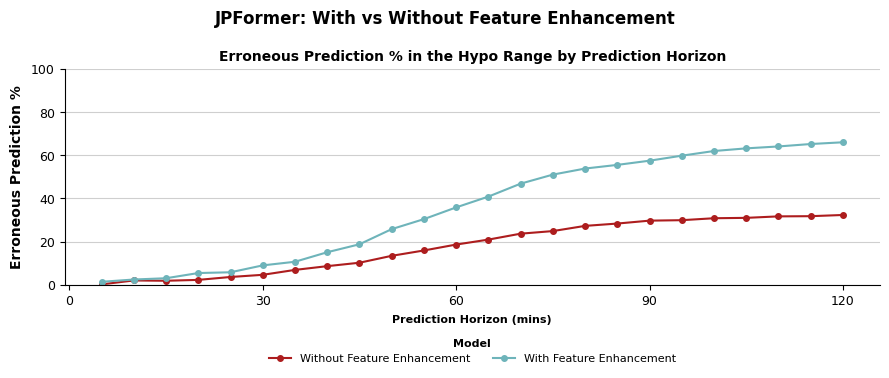

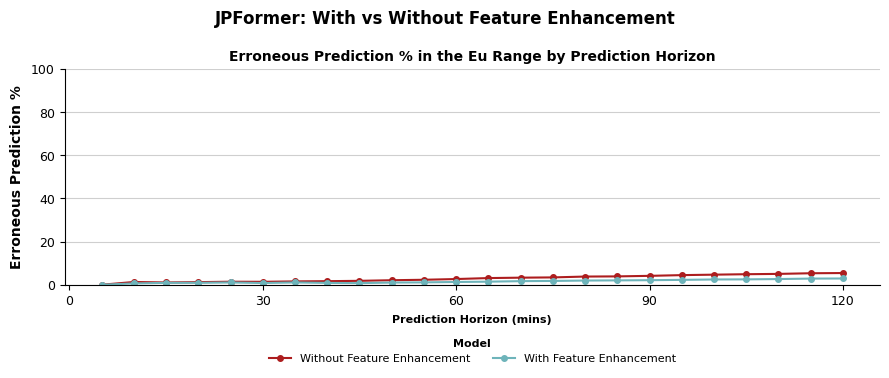

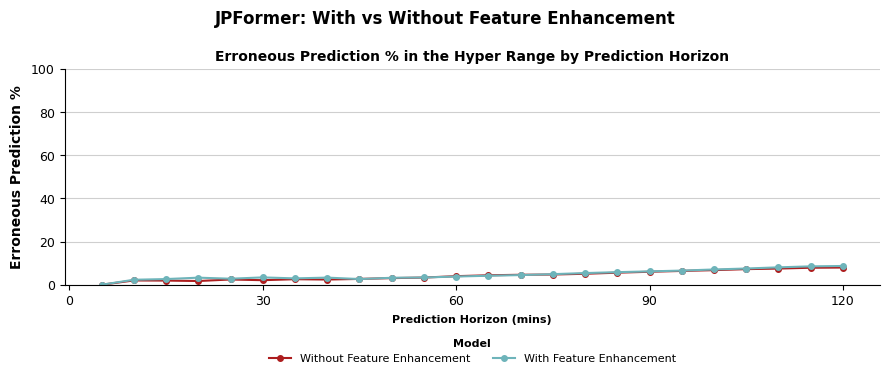

In [16]:
# Call the function with the appropriate arguments
return_ph_chart(model1=jpformer_no_fe_full_results, model2=jpformer_fe_full_results, glycemic_region='hypo')
return_ph_chart(model1=jpformer_no_fe_full_results, model2=jpformer_fe_full_results, glycemic_region='eu')
return_ph_chart(model1=jpformer_no_fe_full_results, model2=jpformer_fe_full_results, glycemic_region='hyper')

In [ ]:


def return_timepoint_summary(no_fe_model, fe_model, glycemic_region):

    timepoints = [30, 60, 90, 120]



    # Create a dictionary to store DataFrames for each timepoint
    timepoint_dfs = {}

    # For each timepoint, create a DataFrame with rows from both models
    for t in timepoints:
        # Create an empty DataFrame
        timepoint_df = pd.DataFrame(columns=['Model', 'AP_percent', 'BP_percent', 'EP_percent', 
                                            'AP_count', 'BP_count', 'EP_count', 'Total_count'])
        
            # Process data for each model using the create_timepoint_ega_dataframe function
        model1_timepoint_table = create_timepoint_ega_dataframe(no_fe_model, glycemic_region)
        model2_timepoint_table = create_timepoint_ega_dataframe(fe_model, glycemic_region)

        # Get data from both models for this timepoint
        no_fe_data = model1_timepoint_table.loc[t].copy()
        fe_data = model2_timepoint_table.loc[t].copy()
        
        # Create rows with model identifiers
        no_fe_row = pd.DataFrame({
            'Model': ['Without feature enhancement'],
            'AP_percent': [no_fe_data['AP_percent']],
            'BP_percent': [no_fe_data['BP_percent']],
            'EP_percent': [no_fe_data['EP_percent']],
            'AP_count': [no_fe_data['AP_count']],
            'BP_count': [no_fe_data['BP_count']],
            'EP_count': [no_fe_data['EP_count']],
            'Total_count': [no_fe_data['Total_count']]
        })
        
        fe_row = pd.DataFrame({
            'Model': ['With feature enhancement'],
            'AP_percent': [fe_data['AP_percent']],
            'BP_percent': [fe_data['BP_percent']],
            'EP_percent': [fe_data['EP_percent']],
            'AP_count': [fe_data['AP_count']],
            'BP_count': [fe_data['BP_count']],
            'EP_count': [fe_data['EP_count']],
            'Total_count': [fe_data['Total_count']]
        })
        
        # Combine the two rows
        timepoint_df = pd.concat([no_fe_row, fe_row])
        
        # Store in dictionary
        timepoint_dfs[t] = timepoint_df

    # Create a figure to visualize EP percentages across timepoints
    fig, axs = plt.subplots(1, 4, figsize=(18, 4))
    axs = axs.flatten()

    # Define custom colors for the models
    model1_color = (173 / 255, 29 / 255, 30 / 255)  # Without Feature Enhancement
    model2_color = (110 / 255, 180 / 255, 186 / 255)  # With Feature Enhancement
    palette = [model1_color, model2_color]

    # Plot bar charts for each timepoint
    for i, t in enumerate(timepoints):
        sns.barplot(
            x='Model', 
            y='EP_percent', 
            data=timepoint_dfs[t], 
            ax=axs[i], 
            palette=palette,
            hue='Model',
            legend=False
        )
        axs[i].set_title(f'Prediction Horizon: {t} mins', fontsize=10, fontweight='bold')
        axs[i].set_ylabel('Erroneous Prediction %', fontsize=8)
        axs[i].set_xlabel('')
        axs[i].set_ylim(0, 100)  # Set consistent y-axis limits
        
        # Add data labels
        for p in axs[i].patches:
            axs[i].annotate(f"{p.get_height():.1f}%", 
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom', fontsize=8, fontweight='bold')
        
        # Set x-tick labels font size to 8
        axs[i].tick_params(axis='x', labelsize=8)
        
        # Remove top and right borders
        sns.despine(ax=axs[i])
    glycemic_region = glycemic_region.capitalize()
    # Add suptitle with more space
    plt.suptitle(f'JPFormer: CG-EGA EP% in {glycemic_region}glycaemic Range by Prediction Horizon', 
                fontsize=12, fontweight='bold')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Increased space between title and plots
    plt.show()

    # Display the comparison tables
    for t in timepoints:
        print(f"\nPrediction Horizon: {t} minutes")
        display(timepoint_dfs[t])




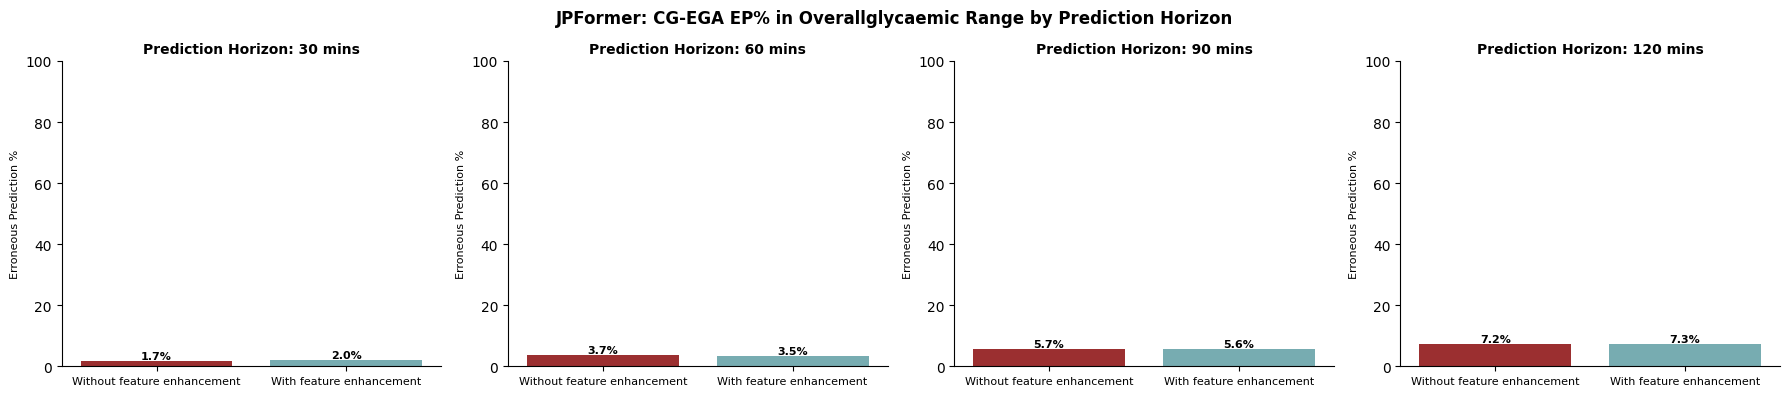


Prediction Horizon: 30 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Without feature enhancement,93.240120,5.029035,1.730845,132304.0,7136.0,2456.0,141896.0
0,With feature enhancement,93.431911,4.607840,1.960249,126689.0,6248.0,2658.0,135595.0



Prediction Horizon: 60 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Without feature enhancement,91.574815,4.756300,3.668884,129941.0,6749.0,5206.0,141896.0
0,With feature enhancement,91.834507,4.682326,3.483167,124523.0,6349.0,4723.0,135595.0



Prediction Horizon: 90 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Without feature enhancement,89.370384,4.957856,5.671760,126813.0,7035.0,8048.0,141896.0
0,With feature enhancement,89.579262,4.778937,5.641801,121465.0,6480.0,7650.0,135595.0



Prediction Horizon: 120 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Without feature enhancement,87.528894,5.257372,7.213734,124200.0,7460.0,10236.0,141896.0
0,With feature enhancement,87.923596,4.798850,7.277554,119220.0,6507.0,9868.0,135595.0


In [18]:
return_timepoint_summary(jpformer_no_fe_full_results, jpformer_fe_full_results, glycemic_region='overall')


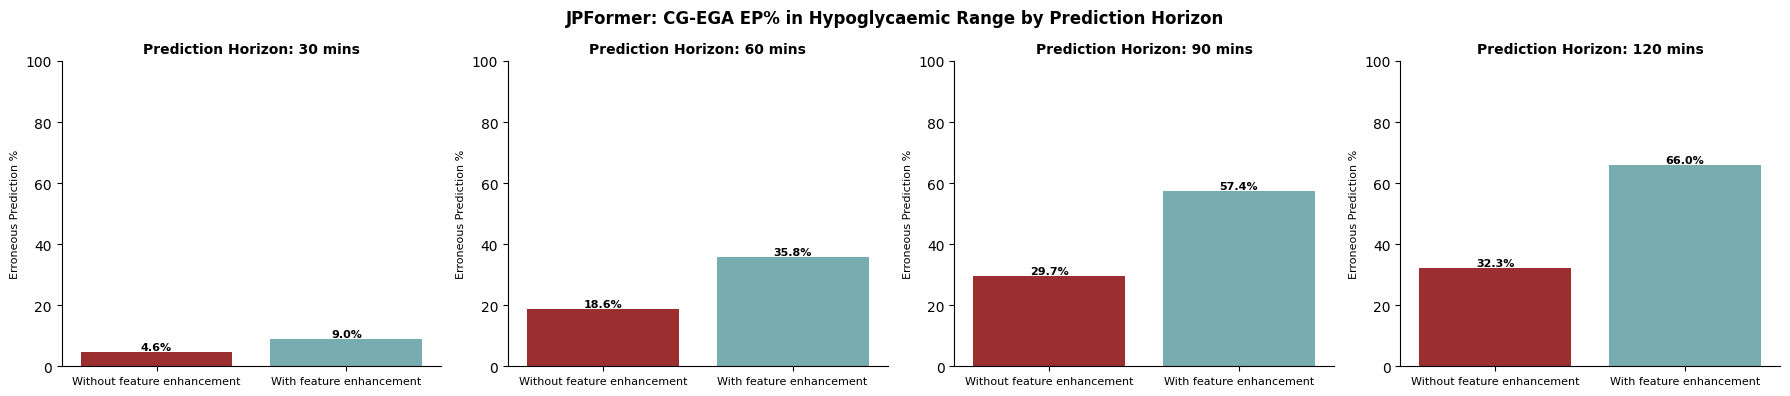


Prediction Horizon: 30 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Without feature enhancement,91.542769,3.842441,4.614791,4741.0,199.0,239.0,5179.0
0,With feature enhancement,88.408178,2.610442,8.981380,4843.0,143.0,492.0,5478.0



Prediction Horizon: 60 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Without feature enhancement,77.612793,3.769275,18.617933,4077.0,198.0,978.0,5253.0
0,With feature enhancement,61.805556,2.375731,35.818713,3382.0,130.0,1960.0,5472.0



Prediction Horizon: 90 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Without feature enhancement,65.848984,4.465312,29.685703,3436.0,233.0,1549.0,5218.0
0,With feature enhancement,40.647285,1.919912,57.432803,2223.0,105.0,3141.0,5469.0



Prediction Horizon: 120 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Without feature enhancement,63.648675,4.043335,32.307990,3290.0,209.0,1670.0,5169.0
0,With feature enhancement,32.529680,1.515982,65.954338,1781.0,83.0,3611.0,5475.0


In [19]:
return_timepoint_summary(jpformer_no_fe_full_results, jpformer_fe_full_results, glycemic_region='hypo')

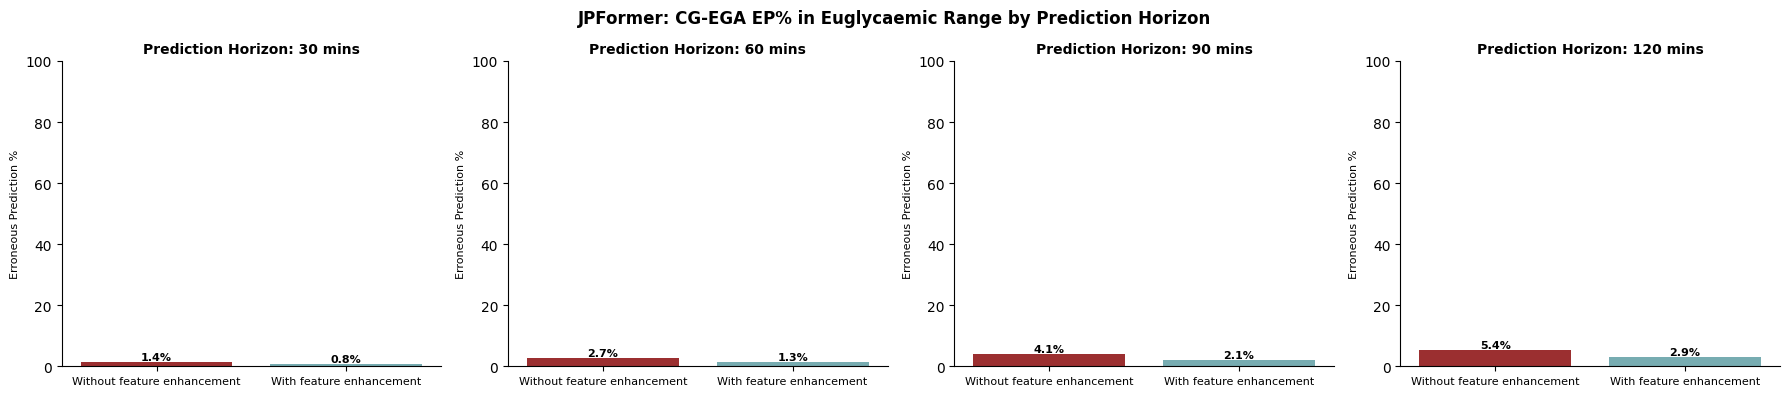


Prediction Horizon: 30 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Without feature enhancement,93.584881,5.036026,1.379093,86114.0,4634.0,1269.0,92017.0
0,With feature enhancement,94.667413,4.520535,0.812052,82887.0,3958.0,711.0,87556.0



Prediction Horizon: 60 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Without feature enhancement,92.591827,4.750196,2.657977,85103.0,4366.0,2443.0,91912.0
0,With feature enhancement,94.001554,4.700249,1.298197,82257.0,4113.0,1136.0,87506.0



Prediction Horizon: 90 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Without feature enhancement,90.872943,4.989951,4.137107,83644.0,4593.0,3808.0,92045.0
0,With feature enhancement,93.053301,4.819015,2.127684,81390.0,4215.0,1861.0,87466.0



Prediction Horizon: 120 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Without feature enhancement,89.262742,5.300836,5.436421,82294.0,4887.0,5012.0,92193.0
0,With feature enhancement,92.026089,5.058939,2.914972,80567.0,4429.0,2552.0,87548.0


In [20]:
return_timepoint_summary(jpformer_no_fe_full_results, jpformer_fe_full_results, glycemic_region='eu')

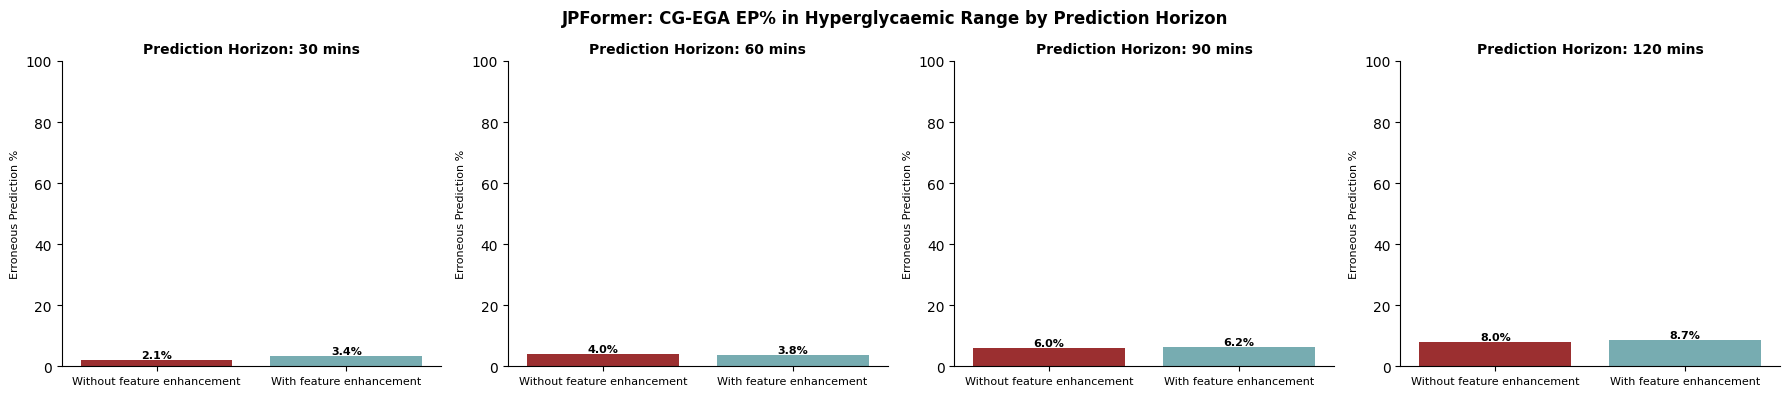


Prediction Horizon: 30 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Without feature enhancement,92.727069,5.152125,2.120805,41449.0,2303.0,948.0,44700.0
0,With feature enhancement,91.536853,5.044524,3.418623,38959.0,2147.0,1455.0,42561.0



Prediction Horizon: 60 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Without feature enhancement,91.124723,4.884756,3.990521,40761.0,2185.0,1785.0,44731.0
0,With feature enhancement,91.240585,4.941690,3.817725,38884.0,2106.0,1627.0,42617.0



Prediction Horizon: 90 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Without feature enhancement,89.021576,4.949253,6.029171,39733.0,2209.0,2691.0,44633.0
0,With feature enhancement,88.729489,5.063291,6.207220,37852.0,2160.0,2648.0,42660.0



Prediction Horizon: 120 minutes


,Model,AP_percent,BP_percent,EP_percent,AP_count,BP_count,EP_count,Total_count
0,Without feature enhancement,86.711277,5.308304,7.980419,38616.0,2364.0,3554.0,44534.0
0,With feature enhancement,86.610918,4.686179,8.702903,36872.0,1995.0,3705.0,42572.0


In [21]:
return_timepoint_summary(jpformer_no_fe_full_results, jpformer_fe_full_results, glycemic_region='hyper')

### **4.1. Statistical Analysis**

In [ ]:
from IPython.display import display

# Function to compute Cramér's V
def cramers_v(chi2, n, contingency_table):
    """Computes Cramér's V effect size from the chi-square test."""
    min_dim = min(np.shape(contingency_table)) - 1  # Min(row-1, col-1)
    return np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else np.nan

# Function to interpret Cramér's V effect size
def interpret_cramers_v(v_value):
    """Provides qualitative interpretation of Cramér's V."""
    if pd.isna(v_value):  
        return "Not Enough Data"
    elif v_value < 0.1:
        return "Negligible Effect"
    elif v_value < 0.3:
        return "Small Effect"
    elif v_value < 0.5:
        return "Medium Effect"
    else:
        return "Large Effect"

# Chi-square analysis function
def return_chi_square_analysis(no_fe_model, fe_model, glycemic_region, model1_name="Model w/o FE", model2_name="Model w/ FE"):
    glycemic_region = glycemic_region.lower()
    data_dist_chi_square_results = []

    print(f"\n Running Chi-Square test for {model1_name} vs {model2_name} ({glycemic_region.capitalize()}glycaemic Range Performance):\n")

    # Copy data to avoid modifying the originals
    df1 = no_fe_model.copy()
    df2 = fe_model.copy()

    # Filter based on glycemic region
    if glycemic_region == 'hypo':
        df1 = df1[df1['glycemic_region'] == 'hypo']
        df2 = df2[df2['glycemic_region'] == 'hypo']
    elif glycemic_region == 'hyper':
        df1 = df1[df1['glycemic_region'] == 'hyper']
        df2 = df2[df2['glycemic_region'] == 'hyper']
    elif glycemic_region == 'eu':
        df1 = df1[df1['glycemic_region'] == 'eu']
        df2 = df2[df2['glycemic_region'] == 'eu']
    else:
        pass  # Use all data

    # Calculate class counts
    df1_counts = df1['CG_EGA_Class'].value_counts()
    df2_counts = df2['CG_EGA_Class'].value_counts()
    
    # Totals
    df1_total = df1_counts.sum()
    df2_total = df2_counts.sum()

    # Contingency table
    contingency_table = [
        [df1_counts.get('AP', 0), df1_counts.get('BE', 0), df1_counts.get('EP', 0)],
        [df2_counts.get('AP', 0), df2_counts.get('BE', 0), df2_counts.get('EP', 0)],
    ]

    # Percentages
    df1_percent = {
        'AP': (df1_counts.get('AP', 0) / df1_total) * 100 if df1_total else 0,
        'BE': (df1_counts.get('BE', 0) / df1_total) * 100 if df1_total else 0,
        'EP': (df1_counts.get('EP', 0) / df1_total) * 100 if df1_total else 0
    }
    df2_percent = {
        'AP': (df2_counts.get('AP', 0) / df2_total) * 100 if df2_total else 0,
        'BE': (df2_counts.get('BE', 0) / df2_total) * 100 if df2_total else 0,
        'EP': (df2_counts.get('EP', 0) / df2_total) * 100 if df2_total else 0
    }

    # Chi-square test
    chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)

    # Cramér's V
    n = np.sum(contingency_table)
    cramers_v_value = cramers_v(chi2, n, contingency_table)
    cramers_v_interpretation = interpret_cramers_v(cramers_v_value)

    # Store result
    data_dist_chi_square_results.append({
        "Model 1": f"{model1_name} ({glycemic_region.capitalize()})",
        "Model 2": f"{model2_name} ({glycemic_region.capitalize()})",
        "Chi2 Statistic": chi2,
        "p-value": p_value,
        "Significant": p_value < 0.05,
        "Cramér's V": cramers_v_value,
        "Cramér's V Interpretation": cramers_v_interpretation
    })

    # Display results
    print(f"\n  χ² = {chi2:.3f}, p = {p_value:.5f}, "
          f"{'Significant' if p_value < 0.05 else 'Not Significant'} | "
          f"Cramér's V = {cramers_v_value:.3f} ({cramers_v_interpretation})\n")

    # Contingency table (readable)
    table_data = pd.DataFrame({
        "AP (Accurate Predictions)": [f"{df1_counts.get('AP', 0)} ({df1_percent['AP']:.2f}%)", 
                                     f"{df2_counts.get('AP', 0)} ({df2_percent['AP']:.2f}%)"],
        "BE (Benign Errors)": [f"{df1_counts.get('BE', 0)} ({df1_percent['BE']:.2f}%)", 
                              f"{df2_counts.get('BE', 0)} ({df2_percent['BE']:.2f}%)"],
        "EP (Erroneous Predictions)": [f"{df1_counts.get('EP', 0)} ({df1_percent['EP']:.2f}%)", 
                                      f"{df2_counts.get('EP', 0)} ({df2_percent['EP']:.2f}%)"]
    }, index=[model1_name, model2_name])

    print("\nContingency Table:")
    display(table_data)

    return pd.DataFrame(data_dist_chi_square_results)

In [23]:
overall_chi_square_results = return_chi_square_analysis(jpformer_no_fe_full_results, jpformer_fe_full_results, glycemic_region='overall')


 Running Chi-Square test for Model w/o FE vs Model w/ FE (Overallglycaemic Range Performance):


  χ² = 87.350, p = 0.00000, Significant | Cramér's V = 0.004 (Negligible Effect)


Contingency Table:


,AP (Accurate Predictions),BE (Benign Errors),EP (Erroneous Predictions)
Model w/o FE,3115416 (91.48%),157269 (4.62%),132819 (3.90%)
Model w/ FE,2982336 (91.64%),145416 (4.47%),126528 (3.89%)


In [24]:
overall_chi_square_results = return_chi_square_analysis(jpformer_no_fe_full_results, jpformer_fe_full_results, glycemic_region='hypo')


 Running Chi-Square test for Model w/o FE vs Model w/ FE (Hypoglycaemic Range Performance):


  χ² = 10157.851, p = 0.00000, Significant | Cramér's V = 0.199 (Small Effect)


Contingency Table:


,AP (Accurate Predictions),BE (Benign Errors),EP (Erroneous Predictions)
Model w/o FE,98011 (78.38%),4622 (3.70%),22416 (17.93%)
Model w/ FE,82187 (62.57%),2684 (2.04%),46476 (35.38%)


In [25]:
overall_chi_square_results = return_chi_square_analysis(jpformer_no_fe_full_results, jpformer_fe_full_results, glycemic_region='eu')


 Running Chi-Square test for Model w/o FE vs Model w/ FE (Euglycaemic Range Performance):


  χ² = 9242.322, p = 0.00000, Significant | Cramér's V = 0.046 (Negligible Effect)


Contingency Table:


,AP (Accurate Predictions),BE (Benign Errors),EP (Erroneous Predictions)
Model w/o FE,2042228 (92.46%),101993 (4.62%),64539 (2.92%)
Model w/ FE,1971850 (93.89%),95720 (4.56%),32546 (1.55%)


In [26]:
overall_chi_square_results = return_chi_square_analysis(jpformer_no_fe_full_results, jpformer_fe_full_results, glycemic_region='hyper')


 Running Chi-Square test for Model w/o FE vs Model w/ FE (Hyperglycaemic Range Performance):


  χ² = 178.648, p = 0.00000, Significant | Cramér's V = 0.009 (Negligible Effect)


Contingency Table:


,AP (Accurate Predictions),BE (Benign Errors),EP (Erroneous Predictions)
Model w/o FE,975177 (90.99%),50654 (4.73%),45864 (4.28%)
Model w/ FE,928299 (90.76%),47012 (4.60%),47506 (4.64%)
